Readme
=======

Requirements:
1. AWS Subscription - for using SageMaker and its associated services
2. AIShield subscription details - URL and subscription key for for making call to image classification service for vulnerability analysis
3. Training script and its requirements file (for required library installation) is already present inside code folder. The code folder can be copied the current working directory and its path need to be specified accordingly in the reference notebook.

Steps :
1. Create a SageMaker notebook with configuration as - conda_tensorflow_p38. 'CPU optimized' configuration should solve the purpose if its not compute heavy. 
2. Import and open the provided notebook and code folder to the environment.
3. Follow the steps as mentioned in the notebook.
4. Variable/parameter values need to be changed as per run configuration.
5. Note: There are 2 requirements file. One at the notebook level is for installing requiremnts required for the notebook ready; and the requirements file present inside code folder is responsible for the deployment related requirements.


# 1.0 Install and Import Libraries

In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 50.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 52.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 625.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 43.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 9.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 37.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successful

In [16]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import cv2
import gzip
import zipfile
import shutil
import tarfile
import requests
from urllib.parse import urlparse
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import boto3
import sagemaker
from sagemaker.tensorflow import TensorFlow, TensorFlowModel
from sagemaker import get_execution_role

import warnings
warnings.filterwarnings("ignore")

In [2]:
sess = sagemaker.Session()
role = get_execution_role()

In [3]:
output_path = "s3://" + sess.default_bucket() + "/tensorflow/mnist"

# 2. Data Download

In [5]:
# Download training and testing data from a public S3 bucket
def download_from_s3(data_dir="/tmp/data", train=True):
    """Download MNIST dataset and convert it to numpy array

    Args:
        data_dir (str): directory to save the data
        train (bool): download training set

    Returns:
        None
    """

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if train:
        images_file = "train-images-idx3-ubyte.gz"
        labels_file = "train-labels-idx1-ubyte.gz"
    else:
        images_file = "t10k-images-idx3-ubyte.gz"
        labels_file = "t10k-labels-idx1-ubyte.gz"

    # download objects
    s3 = boto3.client("s3")
    bucket = f"sagemaker-sample-files"
    for obj in [images_file, labels_file]:
        key = os.path.join("datasets/image/MNIST", obj)
        dest = os.path.join(data_dir, obj)
        if not os.path.exists(dest):
            s3.download_file(bucket, key, dest)
    return


download_from_s3("/tmp/data", True)
download_from_s3("/tmp/data", False)

In [6]:
# upload to the default S3 bucket

prefix = "mnist"
bucket = sess.default_bucket()
loc = sess.upload_data(path="/tmp/data", bucket=bucket, key_prefix=prefix)

channels = {"training": loc, "testing": loc}

# 3. Model Development and Training

In [44]:
input_shape = (28,28,1)
num_classes=10
model_encryption = 0 # 0 if model is uploaded directly as a zip, 1 if model is encryted as .pyc and uploaded as a zip

In [7]:
!pygmentize 'code/train.py'

from __future__ import print_function

import argparse
import gzip
import json
import logging
import os
import traceback

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten

logging.basicConfig(level=logging.DEBUG)

# Define the model object


class SmallConv(Model):
    def __init__(self):
        super(SmallConv, self).__init__()
        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation="relu")
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


# Decode and preprocess data
def convert_to_numpy(data_dir, images_file, labels_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzi

In [10]:
instance_type = "ml.c4.xlarge"

est = TensorFlow(
    entry_point="train.py",
    source_dir="code",  # directory of your training script
    role=role,
    framework_version="2.3.1",
    model_dir=False,  # don't pass --model_dir to your training script
    py_version="py37",
    instance_type=instance_type,
    instance_count=1,
    volume_size=5,
    output_path=output_path,
    hyperparameters={
        "batch-size": 512,
        "epochs": 1,
        "learning-rate": 1e-3,
        "beta_1": 0.9,
        "beta_2": 0.999,
    },
)

In [11]:
# Model training
est.fit(inputs=channels)

2022-12-13 09:32:29 Starting - Starting the training job...
2022-12-13 09:32:54 Starting - Preparing the instances for trainingProfilerReport-1670923949: InProgress
...............
2022-12-13 09:35:14 Downloading - Downloading input data.....2022-12-13 09:36:06.677699: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-12-13 09:36:06.677876: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-12-13 09:36:06.706232: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-12-13 09:36:07,992 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-12-13 09:36:07,997 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-13 09:36:08,172 sagemaker-training-toolkit INFO    

In [12]:
tf_mnist_model_data = est.model_data
print("Model artifact saved at:\n", tf_mnist_model_data)

Model artifact saved at:
 s3://sagemaker-us-east-1-901214976877/tensorflow/mnist/tensorflow-training-2022-12-13-09-32-29-503/output/model.tar.gz


# 4. AIShield Model Vulnerability Check

### 4.1 Prepare Data , Model and Label

> Expected Data Format - all image files in a folder
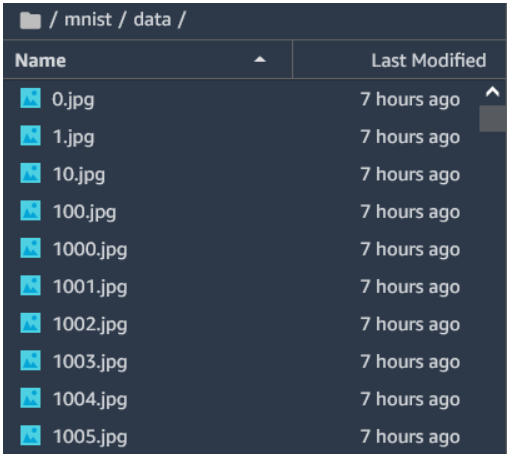

> Expected Label Format - csv file mapping filename to label
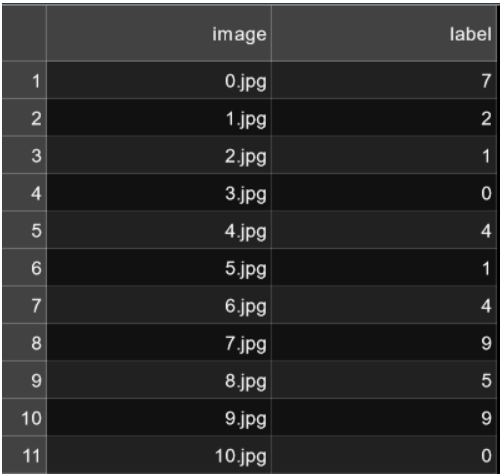

#### 4.1.1 Download the model  to local

In [13]:
s3 = boto3.client("s3")
bucket = sess.default_bucket()

In [23]:
model_key = urlparse(tf_mnist_model_data).path.strip("/")
data_key = "mnist/t10k-images-idx3-ubyte.gz"
label_key = "mnist/t10k-labels-idx1-ubyte.gz"

In [24]:
# model
s3.download_file(bucket, model_key, "model.tar.gz")
# data
s3.download_file(bucket, data_key, "t10k-images-idx3-ubyte.gz")
# label
s3.download_file(bucket, label_key, "t10k-labels-idx1-ubyte.gz")

In [25]:
shutil.unpack_archive('model.tar.gz', 'model')

In [26]:
data_dir="/tmp/data"
images_file = "t10k-images-idx3-ubyte.gz"
labels_file = "t10k-labels-idx1-ubyte.gz"

with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

with gzip.open(os.path.join(data_dir, labels_file), "rb") as f:
    labels = np.frombuffer(f.read(), np.uint8, offset=8)

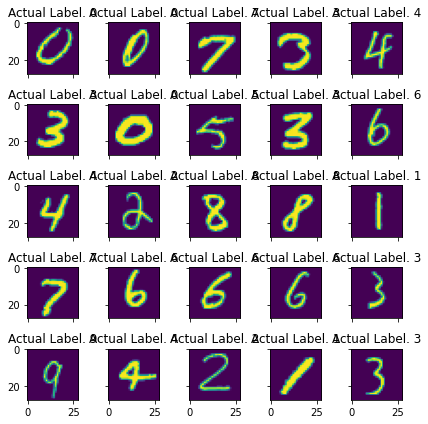

In [27]:
'''
Description: Visualize few random data sample
'''
rows=5

random_indices=random.sample(range(images.shape[0]),rows*rows)
sample_images=images[random_indices,:]
sample_images = np.expand_dims(sample_images, axis=-1) 
sample_labels=labels[random_indices]

fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(6,6),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:])
    axs[subplot_row,subplot_col].set_title("Actual Label. %d" % sample_labels[i])
plt.tight_layout()

#### 4.1.2 Save data, label and model in zip 

In [28]:
%%time
"""
Description: Save data and label
"""
label=pd.DataFrame()
img_name = []
img_label = [] 

if not os.path.isdir("data"):
    os. makedirs("data")
    
for i in range(images.shape[0]):
    cv2.imwrite(os.path.join("data",str(i)+".jpg") ,images[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
    img_name.append(str(i)+".jpg")
    img_label.append(labels[i])
label['image'] = img_name
label["label"] = np.array(img_label)

#write orig_label dataframe
label.to_csv(os.path.join("label.csv"),index=False)

CPU times: user 646 ms, sys: 297 ms, total: 944 ms
Wall time: 1.22 s


In [29]:
"""
Description: Zip data
"""
def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))
      
zipf = zipfile.ZipFile('data.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('data', zipf)
zipf.close()

In [30]:
"""
Description: Zip label
"""
zipfile.ZipFile('label.zip', mode='w').write("label.csv")

In [31]:
"""
Description: Zip model
"""
shutil.make_archive(base_name='model', format='zip', root_dir='model')

'/home/ec2-user/SageMaker/model.zip'

### 4.2 AIShield API Call

In [33]:
"""
Description: AIShield API URL and subscription key
""" 
url="https://3jgjafx6n3.execute-api.eu-central-1.amazonaws.com/AIShieldAPI"
headers={'Cache-Control': 'no-cache',
'x-api-key': "xxxxxxxxxxxxx",
'Org-Id' : "xxxxxxxxxxxxxxxxxxxxxxxx"
}

#### 4.2.1 Model Registration

In [34]:
"""
Description: call Model registration api to get unique model it and url to upload data, model and label
"""
model_registration_url = url + "/AIShieldModelRegistration/v1.5"
model_registration_payload = {
    'task_type':"IC",
    "analysis_type": "MEA"
}
new_request = requests.request(method="POST", url=model_registration_url, headers=headers, params=model_registration_payload)
new_request=json.loads(new_request.text)['Data']
model_id = new_request['ModelID']
data_upload_url = new_request['DataUploadURL']
label_upload_url = new_request['LabelUploadURL']
model_upload_url = new_request['ModelUploadURL']

print('model_id: ', model_id)

model_id:  7bc4a83b-3bbd-412a-baeb-6785b78e6908


In [40]:
"""
Description: Files path
"""
data_path=os.path.join(os.getcwd(),'data.zip') #full path of data zip
label_path=os.path.join(os.getcwd(),'label.zip') #full path of label zip
model_path=os.path.join(os.getcwd(),'model.zip') #full path of model zip

In [41]:
def upload_file(url, file_path):
    new_request = requests.request(method="PUT", url=url, data=open(file_path,'rb'))
    status_cd = new_request.status_code
    if status_cd == 200:
        status = 'upload sucessful'
    else:
        status = 'upload failed'
    return status

In [42]:
"""
Description: Hit AIShield File Upload API
"""

data_upload_status = upload_file(data_upload_url, data_path)
label_upload_status = upload_file(label_upload_url, label_path)
model_upload_status = upload_file(model_upload_url, model_path)
print('data_upload_status: ', data_upload_status)
print('label_upload_status: ', label_upload_status)
print('model_upload_status: ', model_upload_status)

data_upload_status:  upload sucessful
label_upload_status:  upload sucessful
model_upload_status:  upload sucessful


#### 4.2.2 Model Analysis

In [45]:
"""
Description: Payload for AIShield VulnerabilityReport api call
"""
payload={}
payload['model_id']=model_id
payload['use_model_api']="no"
payload['model_api_details']="no"
payload['normalize_data']="Yes"
payload['input_dimensions']=str(input_shape)
payload['number_of_classes']=str(num_classes)
payload['attack_type']="blackbox"  
payload['number_of_attack_queries']=10000
payload['model_framework']='tensorflow'
payload['vulnerability_threshold']="0"
payload['defense_bestonly']="no"
payload['encryption_strategy']= model_encryption

In [47]:
"""
Description: Hit AIShield VulnerabilityReport api
"""
model_analysis_url = url + "/AIShieldModelAnalysis/v1.5"
if data_upload_status == "upload sucessful" and model_upload_status == "upload sucessful" and label_upload_status == "upload sucessful":
    new_request = requests.request(method="POST", url=model_analysis_url, params=payload,headers=headers)
    print(model_analysis_url)
    new_request=json.loads(new_request.text)
    for k, v in new_request.items():
        print("* {} : {}".format(k,v))

https://3jgjafx6n3.execute-api.eu-central-1.amazonaws.com/AIShieldAPI/AIShieldModelAnalysis/v1.5
* ApiVersion : 1.5
* job_id : gAAAAABjmEz9ik50to6l6_1L9XHij_yiY5QNllGUB3BA7psv_TjUIK9hKShVzVY1VZyfBwmL9OVABSfMVafRqEToR7VVGuuA2g==
* monitor_link : http://aismonitor.com.s3-website.eu-central-1.amazonaws.com/?type=ImageClassification&jobid=gAAAAABjmEz9ik50to6l6_1L9XHij_yiY5QNllGUB3BA7psv_TjUIK9hKShVzVY1VZyfBwmL9OVABSfMVafRqEToR7VVGuuA2g==


In [48]:
"""
Description: Get job id from api response
"""
job_id=new_request['job_id']
print(f"Job id : {job_id}")

Job id : gAAAAABjmEz9ik50to6l6_1L9XHij_yiY5QNllGUB3BA7psv_TjUIK9hKShVzVY1VZyfBwmL9OVABSfMVafRqEToR7VVGuuA2g==


In [49]:
def monitor_api_progress(new_job_id):
        job_status_url = url + "/AIShieldModelAnalysis/" + "JobStatusDetailed?JobID=" + new_job_id

        # status dictionary
        status_dictionary = {
            'ModelExploration_Status': 'na',
            'SanityCheck_Status': 'na',
            'QueryGenerator_Status': 'na',
            'VunerabilityEngine_Status': 'na',
            'DefenseReport_Status': 'na',
        }
        counts = [0] * len(status_dictionary)
        failed_api_hit_count = 0
        while True:
            time.sleep(2)
            try:
                job_status_response = requests.request("GET", job_status_url, params={},
                                                       headers=headers)

                job_status_payload = json.loads(job_status_response.text)
                failing_key = 'ModelExploration_Status'
                for i, key in enumerate(status_dictionary.keys()):
                    if status_dictionary[key] == 'na':
                        if job_status_payload[key] == 'inprogress' and status_dictionary[key] == 'na':
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                        elif job_status_payload[key] == 'completed' or job_status_payload[key] == 'passed':
                            status_dictionary[key] = job_status_payload[key]
                            counts[i] += 1
                            print(str(key), ":", status_dictionary[key])

                        if job_status_payload[key] == 'failed':
                            failing_key = key
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                    elif job_status_payload[key] == 'completed' or job_status_payload[key] == 'passed':
                        status_dictionary[key] = job_status_payload[key]
                        if counts[i] < 1:
                            print(str(key), ":", status_dictionary[key])
                        counts[i] += 1

                    else:
                        if job_status_payload[key] == 'failed':
                            failing_key = key
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                if job_status_payload[failing_key] == 'failed':
                    break

                if status_dictionary['VunerabilityEngine_Status'] == 'passed' or status_dictionary[
                    'VunerabilityEngine_Status'] == 'completed' and job_status_payload[
                    'CurrentStatus'] == "Defense generation is not triggered":
                    print("\n Vulnerability score {} failed to cross vulnerability threshoold of {}".format(
                        job_status_payload['VulnerabiltyScore'], payload['vulnerability_threshold']))
                    break
                if job_status_payload['DefenseReport_Status'] == 'completed':
                    break
            except Exception as e:
                failed_api_hit_count += 1
                print("Error {}. trying {} ...".format(str(e), failed_api_hit_count))
                if failed_api_hit_count >= 3:
                    break
        return status_dictionary

In [50]:
"""
Description: Continuos monitoring of job progress
"""
status_dictionary = monitor_api_progress(new_job_id=job_id)

ModelExploration_Status : completed
SanityCheck_Status : passed
QueryGenerator_Status : inprogress
QueryGenerator_Status : completed
VunerabilityEngine_Status : inprogress
VunerabilityEngine_Status : completed
DefenseReport_Status : inprogress
DefenseReport_Status : completed


#### 4.2.3 Get output artifacts and upload to S3

In [53]:
def make_directory(directory):
    """
    create directory

    Parameters
    ----------
    directorys : list containing the directorys path to create 
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

def delete_directory(directorys):
    """
    delete directory 

    Parameters
    ----------
    directorys : list containing the directorys to deleate along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
            else:
                print("Failed to removed: {}".format(d))
                

In [63]:
artifact_path = os.path.join(os.getcwd(), "aishield_output_artifacts")

#deleting folder
# delete_directory(directorys=[report_path])

#creating folder
make_directory([report_path])

directory /home/ec2-user/SageMaker/aishield_output_artifacts already exist


In [64]:
def download_artifact(job_id,report_path=os.getcwd(), report_type='Vulnerability', file_format=0):
    """
    job_id: job_id  received after successful api call
    report_type: report to be downloaded
    file_format: change file_format to : 0- all report in zip 
                        1- report in .txt 
                        2- report in .pdf
                        3- report in .json
                        4- report in .xml
    """
    report_url = url + "/AIShieldModelAnalysis/" + "GetReport?JobID=" + str(
        job_id) + "&ReportType=" + report_type + "&FileFormat=" + str(file_format)

    headers1=headers
    headers1["content-type"]= "application/zip"

    response = requests.request("GET", report_url, params={}, headers=headers1)

    if file_format == 0 or "Attack_samples":
        with open(os.path.join(report_path, report_type + ".zip"), 'wb') as f:
            f.write(response.content)
    elif file_format == 1:
        with open(os.path.join(report_path, report_type + ".txt"), 'wb') as f:
            f.write(response.content)
    elif file_format == 2:
        with open(os.path.join(report_path, report_type + ".pdf"), 'wb') as f:
            f.write(response.content)
    elif file_format == 3:
        with open(os.path.join(report_path, report_type + ".json"), 'wb') as f:
            f.write(response.content)
    elif file_format == 4:
        with open(os.path.join(report_path, report_type + ".xml"), 'wb') as f:
            f.write(response.content)

In [66]:
"""
Description: download generated artifact
"""
file_format = 0  # if 0, download in zip

if status_dictionary["VunerabilityEngine_Status"] == 'completed':
    download_artifact(job_id=job_id, report_path=artifact_path, report_type='Vulnerability', file_format=file_format) 
    download_artifact(job_id=job_id, report_path=artifact_path, report_type='Attack_samples', file_format=file_format)

if status_dictionary["DefenseReport_Status"] == 'completed':
    download_artifact(job_id=job_id, report_path=artifact_path, report_type='Defense', file_format=file_format)
    download_artifact(job_id=job_id, report_path=artifact_path, report_type='Defense_artifact', file_format=file_format)

In [71]:
# Extract vulnerability and defense reports/artifacts
if file_format == 0:
    vulnerability_report_path = os.path.join(artifact_path, 'Vulnerability.zip')
    defense_report_path = os.path.join(artifact_path, 'Defense.zip')
    defense_artifacts_path = os.path.join(artifact_path, 'Defense_artifact.zip')

    shutil.unpack_archive(vulnerability_report_path, os.path.join(artifact_path, 'Vulnerability'))
    shutil.unpack_archive(defense_report_path, os.path.join(artifact_path, 'Defense'))
    shutil.unpack_archive(defense_artifacts_path, os.path.join(artifact_path, 'Defense_artifact'))

# 5. Model deployments

### 5.1 Converting Defense model to SageMaker compatible - TensorFlow ProtoBuf format for deployment

In [76]:
defense_model_folder = os.path.join(artifact_path, 'Defense_artifact')  
loaded_defense_model = keras.models.load_model(os.path.join(defense_model_folder, 'defense_model.h5'))

In [77]:
model_version = '1'
export_dir = os.path.join(defense_model_folder, model_version)
tf.saved_model.save(loaded_defense_model, export_dir)

INFO:tensorflow:Assets written to: /home/ec2-user/SageMaker/aishield_output_artifacts/Defense_artifact/1/assets


INFO:tensorflow:Assets written to: /home/ec2-user/SageMaker/aishield_output_artifacts/Defense_artifact/1/assets


In [80]:
def_mdl_tar_path = os.path.join(defense_model_folder, 'model.tar.gz')
with tarfile.open(def_mdl_tar_path, mode='w:gz') as archive:
    archive.add(export_dir, recursive=True)

In [81]:
# upload the defense model to S3 bucket
prefix = "mnist-defense"
bucket = sess.default_bucket()
defense_model_loc = sess.upload_data(path=def_mdl_tar_path, bucket=bucket, key_prefix=prefix)
print("Defense model artifact saved at:\n", defense_model_loc)

Defense model artifact saved at:
 s3://sagemaker-us-east-1-901214976877/mnist-defense/model.tar.gz


### 5.2 Deploy

In [82]:
test_data = np.random.rand(2, 28, 28, 1)

#### 5.2.1 Deploy original model

In [85]:
tf_mnist_model_data = est.model_data
print("Model artifact saved at:\n", tf_mnist_model_data)

Model artifact saved at:
 s3://sagemaker-us-east-1-901214976877/tensorflow/mnist/tensorflow-training-2022-12-13-09-32-29-503/output/model.tar.gz


In [86]:
predictor = est.deploy(initial_instance_count=1, instance_type="ml.c4.large")
print('predictor endpoint: ', predictor.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


predictor endpoint:  tensorflow-training-2022-12-13-10-35-29-071


In [87]:
# sanity check
prediction = np.argmax(predictor.predict(test_data)['predictions'], axis=1)
print(prediction)

[5 5]


#### 5.2.2 Deploy defense model

In [88]:
defense_model_loc

's3://sagemaker-us-east-1-901214976877/mnist-defense/model.tar.gz'

In [89]:
defense_model = TensorFlowModel(model_data=defense_model_loc, role=role, framework_version="2.3.1",)

In [90]:
defense_predictor = defense_model.deploy(initial_instance_count=1, instance_type="ml.c4.large")
print('Defense predictor endpoint: ', defense_predictor.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Defense predictor endpoint:  tensorflow-inference-2022-12-13-10-38-59-819


In [91]:
# sanity check
np.argmax(defense_predictor.predict(test_data)['predictions'], axis=1)

array([1, 1])

# 6. Detect Attack

In [92]:
def pred_without_ais(data):
    prediction = np.argmax(predictor.predict(data)['predictions'], axis=1)
    return prediction

In [145]:
def pred_with_ais(data):
    # passing to AIS-defense model
    defense_prediction =  np.argmax(defense_predictor.predict(data)['predictions'], axis=1)
    # passing to actual model
    orig_prediction = np.argmax(predictor.predict(data)['predictions'], axis=1)
    # Detect attack based on defense model prediction; otherwise return the original model prediction
    prediction = ['Attack' if def_pred==1 else orig_prediction[idx] for idx, def_pred in enumerate(defense_prediction)]
    return prediction

### 6.1. On Actual Data

In [94]:
'''
Description: Visualize few random data sample
'''
rows=5

random_indices=random.sample(range(images.shape[0]),rows*rows)
sample_images=images[random_indices,:]
sample_images = np.expand_dims(sample_images, axis=-1) 
sample_labels=labels[random_indices]

In [95]:
pred_wo_ais = pred_without_ais(sample_images)
pred_wo_ais

array([7, 9, 3, 3, 3, 9, 5, 4, 3, 4, 0, 4, 0, 3, 1, 0, 6, 2, 9, 3, 9, 8,
       2, 6, 5])

In [96]:
# prediction with AIS integrationa
pred_w_ais = pred_with_ais(sample_images)
pred_w_ais

[7, 9, 3, 3, 3, 9, 5, 4, 3, 4, 0, 4, 0, 3, 1, 0, 6, 2, 9, 3, 9, 8, 2, 6, 5]

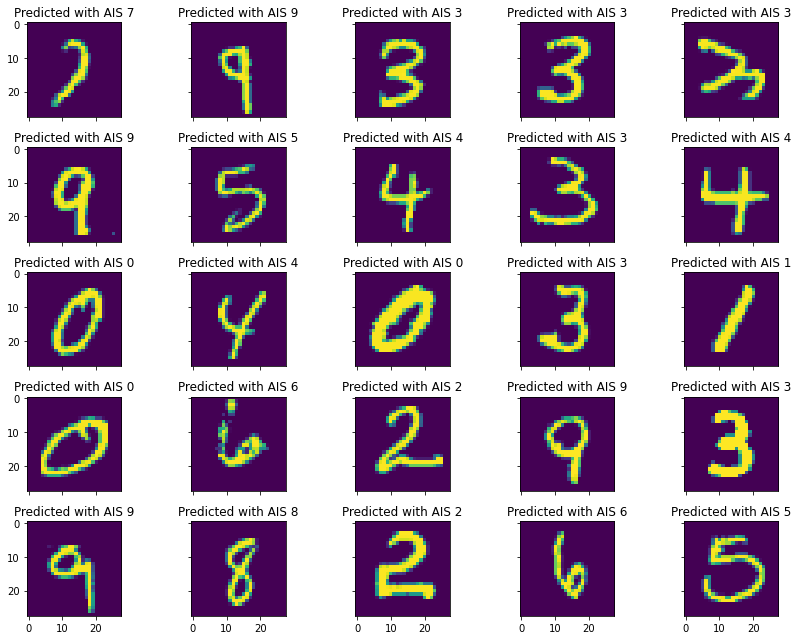

In [97]:
rows = 5
fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:])
    axs[subplot_row,subplot_col].set_title("Predicted with AIS %d" % pred_w_ais[i])
plt.tight_layout()

### 6.2. On Attack Data

In [136]:
'''
Description: Create quereis for model extraction
'''
sample_attack_queries = np.random.rand(25,28,28,1)*0
for i in (range(sample_attack_queries.shape[0])):
    for _ in range(np.random.randint(0,20)):
        x1 = np.random.randint(0,20)
        y1 = np.random.randint(0,20)
        x2 = np.random.randint(x1,28)
        y2 = np.random.randint(y1,28)
        sample_attack_queries[i,x1:x2,y1:y2,0] = 1        

#### 6.2.1 Without AIShield Defense

In [126]:
# prediction without AIShield defense
pred_wo_ais = pred_without_ais(sample_attack_queries)

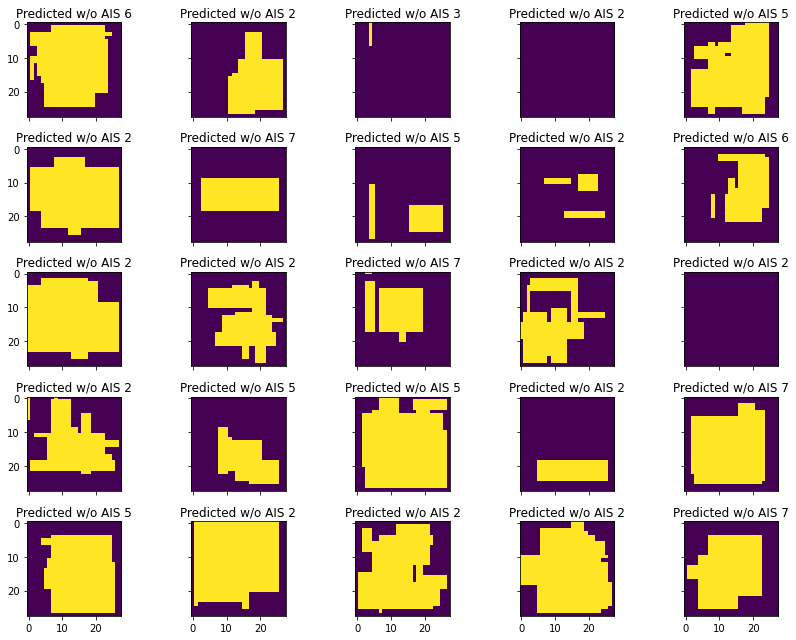

In [127]:
rows = 5
fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_attack_queries[i,:])
    axs[subplot_row,subplot_col].set_title("Predicted w/o AIS %d" % pred_wo_ais[i])
plt.tight_layout()

#### 6.2.2 With AIShield Defense

In [148]:
# prediction with AIShield defense
pred_ais = pred_with_ais(sample_attack_queries)

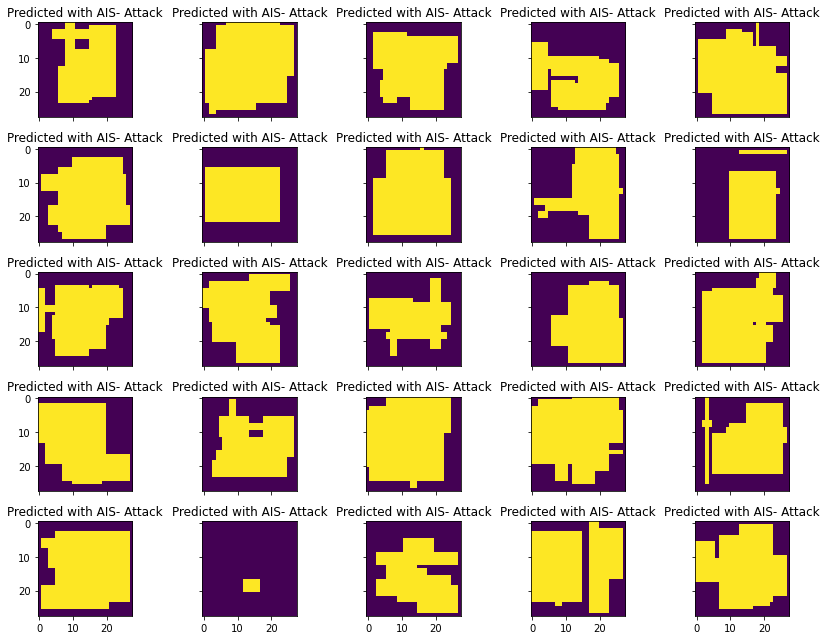

In [147]:
rows = 5
fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_attack_queries[i,:])
    axs[subplot_row,subplot_col].set_title("Predicted with AIS- %s" % str(pred_ais[i]))
plt.tight_layout()

# Clean-up deployments¶

In [ ]:
predictor.delete_endpoint()

In [ ]:
defense_predictor.delete_endpoint()